## ViEWS with random forest
- no lag
- and with lag 
- country codes [here](https://www.uky.edu/~clthyn2/replace_ccode_country.do)

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import sys
sys.path.append("/Users/kaylahuang/Desktop/conflicts/components/")
sys.path.append("/Users/kaylahuang/Desktop/conflicts/yun_ff/")

from views_cleaner import VIEWSCleaner

import enums

In [3]:
filename = '../data/views/cm_features.parquet'
gw_id = 490
country = "drc"

# # not a complete list, this file no longer exists
# countries_df = pd.read_csv('../data/views23/countries.csv')
# country_name = countries_df.loc[countries_df['id'] == gw_id, 'name'].values[0]
# print(f"The country with id {gw_id} is {country_name}")


Removing columns: ['ged_os', 'ged_ns', 'acled_sb', 'acled_sb_count', 'acled_os']
(412, 121)


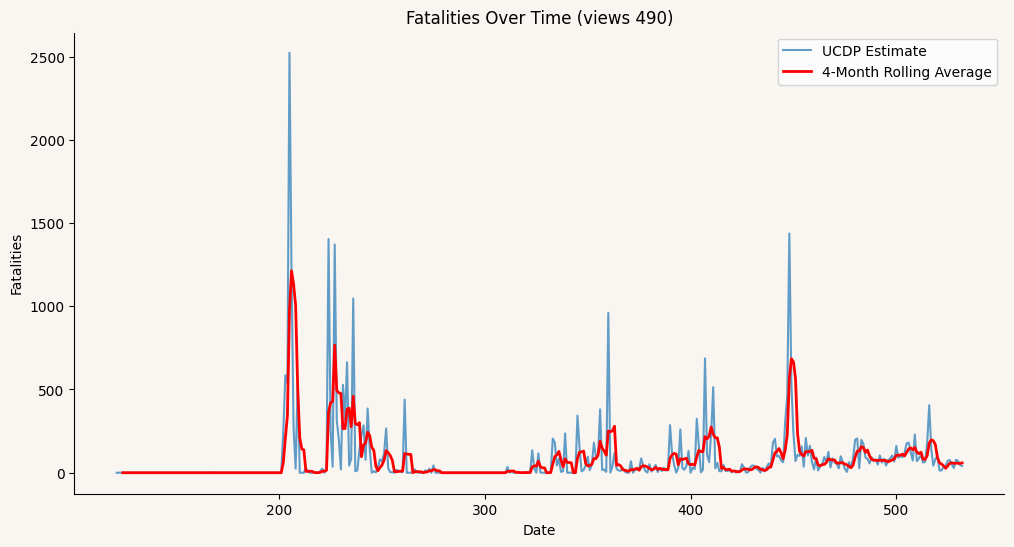

In [4]:
# cleaner = VIEWSCleaner(filename, gw_id)
cleaner = VIEWSCleaner(filename, gw_id, trim_full=False)

original_features = cleaner.features # already aggregated by month
X = original_features.copy()
print(X.shape)
cleaner.plot(n=4)

# X.to_csv(f'../data/views/{country}.csv')

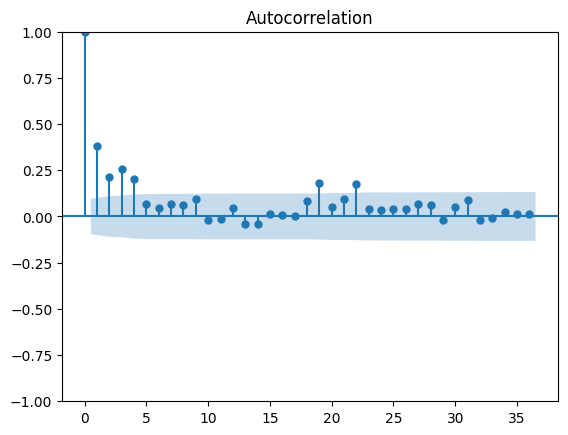

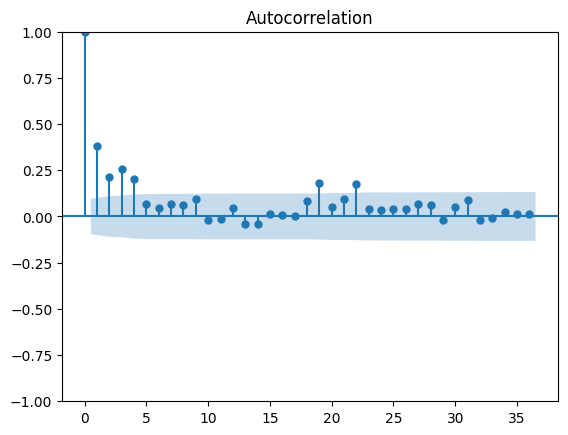

In [5]:
# look at the autocorrelation for each time series 
# to determine the number of lags to take

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(X['ged_sb'], lags=36) 

In [11]:
from statsmodels.tsa.stattools import acf
acf_values = acf(X['ged_sb'], alpha=0.05)
print(acf_values[0])
print(acf_values[1])

[ 1.00000000e+00  3.81218310e-01  2.14534922e-01  2.54218170e-01
  2.00993049e-01  6.49818915e-02  4.42214958e-02  6.61228010e-02
  6.00264247e-02  9.46850344e-02 -1.71100382e-02 -1.40754492e-02
  4.48179568e-02 -3.97096333e-02 -4.19758153e-02  1.32049926e-02
  9.90627620e-03 -2.82377919e-06  8.31994279e-02  1.82733766e-01
  4.99698356e-02  9.52704490e-02  1.76615006e-01  3.83572783e-02
  3.71688492e-02  3.83461356e-02  4.07546428e-02]
[[ 1.          1.        ]
 [ 0.28465781  0.4777788 ]
 [ 0.10483545  0.32423439]
 [ 0.14067414  0.3677622 ]
 [ 0.08226058  0.31972552]
 [-0.05688172  0.1868455 ]
 [-0.07796476  0.16640776]
 [-0.05621259  0.1884582 ]
 [-0.06264175  0.1826946 ]
 [-0.02825671  0.21762678]
 [-0.14072984  0.10650976]
 [-0.13771733  0.10956643]
 [-0.07883886  0.16847478]
 [-0.16351782  0.08409855]
 [-0.16590269  0.08195106]
 [-0.11085438  0.13726437]
 [-0.1141662   0.13397875]
 [-0.12408268  0.12407703]
 [-0.04088043  0.20727928]
 [ 0.05813484  0.3073327 ]
 [-0.07710328  0.177

In [5]:
def create_sliding_window(data, window_size):
    for i in range(1, window_size + 1):
        data[f'lag_{i}'] = data['ged_sb'].shift(i)
    return data.dropna()

window_size = 5 # dictated by the above
X = create_sliding_window(X, window_size)
X.head() # last WINDOW_SIZE columns are the lags

,month_id,country_id,gleditsch_ward,ged_sb,ged_sb_tsum_24,wdi_sp_pop_totl,ged_sb_tlag_1,ged_sb_tlag_2,ged_sb_tlag_3,ged_sb_tlag_4,...,renewable_internal_pcap_t48,renewable_pcap_t48,splag_1_decay_ged_sb_5,splag_1_decay_ged_os_5,splag_1_decay_ged_ns_5,lag_1,lag_2,lag_3,lag_4,lag_5
967,126,167,490,0,0.0,34825891.0,0.0,0.0,0.0,0.0,...,29331.372781,41813.50142,3.162288,3.817477,1.010085,0.0,0.0,0.0,0.0,0.0
1134,127,167,490,0,0.0,34825891.0,0.0,0.0,0.0,0.0,...,29331.372781,41813.50142,3.157668,3.708800,0.981330,0.0,0.0,0.0,0.0,0.0
1301,128,167,490,0,0.0,34825891.0,0.0,0.0,0.0,0.0,...,29331.372781,41813.50142,3.153180,3.988528,0.953393,0.0,0.0,0.0,0.0,0.0
1468,129,167,490,0,0.0,34825891.0,0.0,0.0,0.0,0.0,...,29331.372781,41813.50142,4.124016,3.957978,0.926252,0.0,0.0,0.0,0.0,0.0
1635,130,167,490,0,0.0,34825891.0,0.0,0.0,0.0,0.0,...,29331.372781,41813.50142,4.092017,3.986022,0.899883,0.0,0.0,0.0,0.0,0.0


In [6]:
# ADDING VARS: set war var
war_dates = enums.WAR_DATES.get(country)
if war_dates:
    cleaner.set_war_var(X, war_dates)

X = cleaner.features_war_dates
print(X.shape)

[(202, 209), (224, 283)]
(407, 128)


[77, 79, 83, 98, 101, 105, 107, 110, 234, 281, 322]
       Month  Peak Value
14981    203         585
15355    205        2523
16103    209         547
18908    224        1404
19469    227        1371


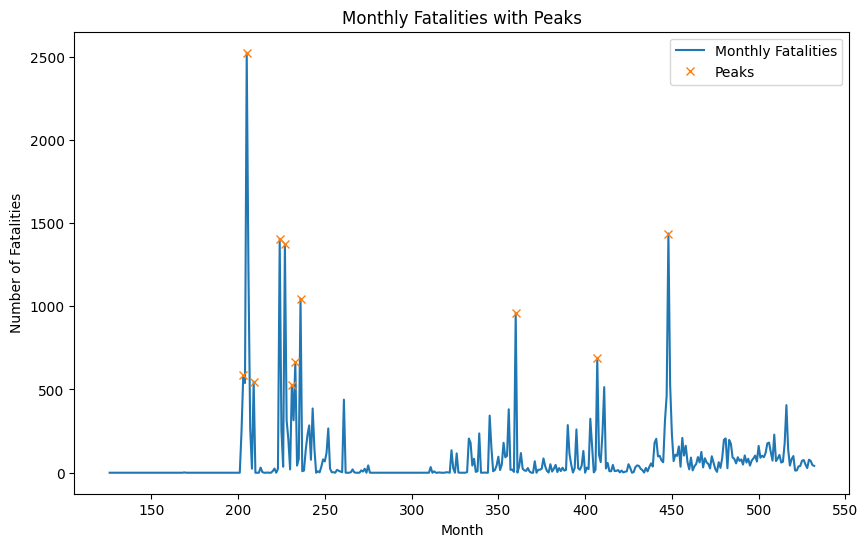

In [7]:
# ADDING VARS: set peak var w poisson process
from scipy.signal import find_peaks

data = X['ged_sb'].copy()
data = pd.Series(data)


height_threshold = data.mean() + 2 * data.std()
peaks, _ = find_peaks(data, height=height_threshold)

# TODO can use moving average
# df = X.copy()
# window_size = 3
# df['moving_avg'] = df['ged_sb'].rolling(window=window_size).mean()
# peaks, _ = find_peaks(df['ged_sb'], height=df['moving_avg'])
  
peak_indices = list(peaks)
print(peak_indices)

peaks_df = pd.DataFrame({
    'Month': X['month_id'].iloc[peak_indices],
    'Peak Value': data.iloc[peak_indices]
})

print(peaks_df.head())

# Plot the data and peaks
plt.figure(figsize=(10, 6))
plt.plot(X["month_id"], data, label='Monthly Fatalities')
plt.plot(peaks_df["Month"], peaks_df["Peak Value"], "x", label='Peaks')
plt.title('Monthly Fatalities with Peaks')
plt.xlabel('Month')
plt.ylabel('Number of Fatalities')
plt.legend()
plt.show()

In [8]:
## POISSON PROCESS CODE
import numpy as np
import pandas as pd
from scipy.signal import find_peaks

# calculate inter-peak intervals
inter_peak_intervals = np.diff(peaks)

# estimate average time between peaks (lambda)
lambda_est = 1 / np.mean(inter_peak_intervals)

# model the poisson process
def poisson_process_prob(t, lambda_est):
    return 1 - np.exp(-lambda_est * t)

# est the probability of future peaks
future_months = np.arange(1, 25)  # Example: next 24 months
probabilities = poisson_process_prob(future_months, lambda_est)
print(probabilities)

# Create a new column "peak_prob" in X
X['peak_prob'] = X['since_war_start'].apply(lambda t: poisson_process_prob(t, lambda_est))


[0.03999456 0.07838955 0.11524896 0.15063418 0.18460419 0.21721559
 0.24852271 0.27857771 0.30743068 0.33512968 0.36172088 0.38724857
 0.41175529 0.43528188 0.45786753 0.47954988 0.50036505 0.52034773
 0.53953121 0.55794746 0.57562715 0.59259976 0.60889355 0.62453568]


In [52]:
# # STANDARDIZATION APPROACH
# from sklearn.preprocessing import StandardScaler
# from sklearn.feature_selection import VarianceThreshold

# def remove_low_variance_features(df, threshold=0.01):
#     scaler = StandardScaler()
#     df_standardized = scaler.fit_transform(df)
    
#     selector = VarianceThreshold(threshold=threshold)
#     selector.fit(df_standardized)
    
#     features_kept = df.columns[selector.get_support(indices=True)]
#     df_reduced = df[features_kept]
#     return df_reduced

# threshold = 0.01  
# df_reduced = remove_low_variance_features(X, threshold)

# print(X.shape)
# print(df_reduced.shape)

In [9]:
# COEFFICIENT OF VARIATION APPROACH

def remove_low_variance_features_cv(df, threshold=0.01):
    cv = df.std() / df.mean()
    features_kept = cv[cv > threshold].index
    df_reduced = df[features_kept]
    return df_reduced

threshold = 0.01
df_reduced = remove_low_variance_features_cv(X, threshold)

print(X.shape)
print(df_reduced.shape)
print("Columns removed:\n", set(X.columns) - set(df_reduced.columns))

X = df_reduced

(407, 129)
(407, 120)
Columns removed:
 {'groundwater_export_t48', 'gleditsch_ward', 'vdem_v2x_accountability', 'wdi_sm_pop_netm', 'vdem_v2clrgunev', 'vdem_v2x_veracc', 'vdem_v2x_horacc', 'country_id', 'splag_wdi_sm_pop_netm'}


In [11]:
import xgboost as xgb
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LogisticRegression
from sklearn.svm import SVR
# from lightgbm import LGBMRegressor

def predict_date(input_month, model_name='RF'):
    ## TRAINING DATA
    pre_date = X[X['month_id'] < input_month].tail(36)
    X_train = pre_date.drop(columns=["ged_sb", "month_id"]) # last 36
    y_train = pre_date["ged_sb"] # corresponding fatalities

    ## MODEL SELECTION AND FIT
    model = None
    if model_name == 'RF':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    elif model_name == 'XGB':
        model = xgb.XGBRegressor(n_estimators=100, random_state=42)
    elif model_name == 'EN':
        model = ElasticNet(alpha=1.0, l1_ratio=0.1, max_iter=1000, random_state=40)
    # elif model_name == 'SVM':
    #     model = SVR(C=10, epsilon=0.1)
    # elif model_name == 'LGBM':
    #     model = LGBMRegressor(n_estimators=100, random_state=42)
    elif model_name == 'Lasso':
        model = Lasso(alpha=1.0, max_iter=1000, random_state=42)
    elif model_name == 'Ridge':
        model = Ridge(alpha=1.0, max_iter=1000, random_state=42)
    # elif model_name == 'Logistic':
    #     model = LogisticRegression(max_iter=1000, random_state=42)
        
    model.fit(X_train, y_train)
    
    ## MODEL PREDICTION
    row = X[X['month_id'] == input_month]
    prediction = model.predict(row.drop(columns=["ged_sb", "month_id"]))
    
    if model_name in ['EN', 'Lasso', 'Ridge']:
        prediction = np.clip(prediction, a_min=0, a_max=None)
        
    importances = []
    if model_name in ['RF', 'XGB']:
        importances = model.feature_importances_
    
    return prediction[0], row["ged_sb"].values[0], importances

# set the prediction function
prediction_function = lambda date: predict_date(date, model_name='RF')



In [104]:
# SKIP THIS CELL
def ensemble_prediction(input_month):
    models = ['RF', 'XGB', 'EN']
    base_predictions = []
    actual_values = []
    
    # Adjust to use data only from months prior to the input_month
    for model in models:
        pred, actual, imp = predict_date(input_month - 1, model_name=model)
        base_predictions.append(pred)
        actual_values.append(actual)
    
    # Assuming base_predictions are used as features for the meta model
    # Meta model could be a simple linear regression for combining predictions
    from sklearn.linear_model import LinearRegression
    meta_model = LinearRegression()
    
    # Reshape base_predictions for training the meta model
    # Here we assume all actual values are the same (as they should be for the same input_month)
    X_meta = np.array(base_predictions).reshape(1, -1)
    y_meta = np.array(actual_values[0]).reshape(-1)
    
    # Fit the meta model
    meta_model.fit(X_meta, y_meta)
    
    # Use the meta model to make the final prediction
    final_prediction = meta_model.predict(X_meta)[0]
    
    imp = 0  # No feature importances from meta model in this simple case
    return final_prediction, actual_values[0], imp


In [63]:
# SKIP THIS CELL
# calculate importances 
month = 200
WIDTH = 5

importances_list = [] 

for m in range(month, month+WIDTH):
    # p, true, feature_imp = prediction_function(m)
    p, true, feature_imp = prediction_function(m)
    print("prediction: ", p)
    print("true: ", true)
    importances_list.append(feature_imp)

prediction:  792.783042129071
true:  290
prediction:  713.1436919601547
true:  713
prediction:  834.5906833788322
true:  74
prediction:  890.7208627251675
true:  11
prediction:  807.6068680865719
true:  111


/Users/kaylahuang/opt/anaconda3/envs/c-network/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.145e+06, tolerance: 5.521e+02
  model = cd_fast.enet_coordinate_descent(
/Users/kaylahuang/opt/anaconda3/envs/c-network/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.070e+06, tolerance: 5.474e+02
  model = cd_fast.enet_coordinate_descent(
/Users/kaylahuang/opt/anaconda3/envs/c-network/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

In [78]:
# # plotting feature importance for one model 
# importances = feature_imp
# feature_names = X.drop(columns=["ged_sb"]).columns

# # Get the threshold for the top 25% important features
# threshold = np.percentile(importances, 75)
# filtered_importances = importances[importances >= threshold]
# filtered_feature_names = feature_names[importances >= threshold]

# plt.figure(figsize=(10, 6))
# plt.barh(filtered_feature_names, filtered_importances)
# plt.xlabel('Feature Importance')
# plt.ylabel('Feature Names')
# plt.title('Top 25% Feature Importances')
# plt.show()

In [ ]:
TOP_N = 10
feature_names = X.drop(columns=["ged_sb", "month_id"]).columns

# Create a DataFrame to store feature importances from all models
importance_df = pd.DataFrame(importances_list, columns=feature_names)

# Calculate the mean importance for each feature across all models
mean_importances = importance_df.mean(axis=0)

# Get the top 5 features based on mean importance
top_features = mean_importances.nlargest(TOP_N).index

print(list(top_features))
top_importances = importance_df[top_features]

plt.figure(figsize=(10, 6))
bar_width = 0.1

# positions for the bars
positions = np.arange(len(top_features))

# model's feature importances next to each other
for i, importances in enumerate(importances_list):
    plt.barh(positions + i * bar_width, top_importances.iloc[i], bar_width, alpha=0.5, label=f'Model {i+1}')

# y ticks in the middle of the grouped bars
plt.yticks(positions + bar_width * (len(importances_list) - 1) / 2, top_features)

plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title(f'top {TOP_N} features for country code {gw_id}')
plt.legend()
plt.show()

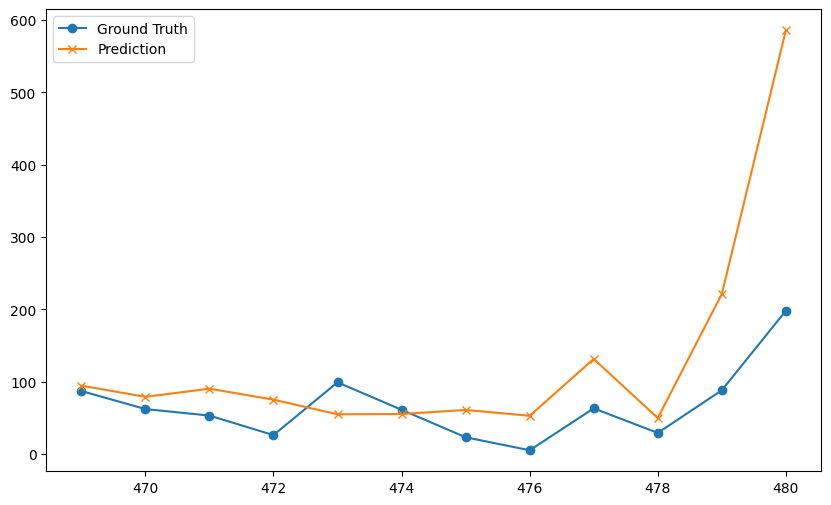

In [15]:
# dates_to_predict = X['month_id'].values[100:]
START = 469
WIDTH = 12
dates_to_predict = [i for i in range(START, START+WIDTH)]

ground_truth = []
predictions = []

for date in dates_to_predict:
    p, t, feature_imp = prediction_function(date)
    ground_truth.append(t)
    predictions.append(p)

plt.figure(figsize=(10, 6))

plt.plot(dates_to_predict, ground_truth, label='Actual', marker='o')
plt.plot(dates_to_predict, predictions, label='Predicted', marker='x')
plt.legend(['Ground Truth', 'Prediction'])
plt.show()




In [1]:
df = {
    'month_id': dates_to_predict,
    'country_id': [gw_id] * WIDTH,
    'new_forecast': predictions
}

new_forecast_df = pd.DataFrame(df)

save_filename = f'../hadr/views_testing/{country}_rf_forecasts_2019.csv'
import os 

# Check if the file already exists
if os.path.isfile(save_filename):
    # If it exists, read the existing file
    existing_df = pd.read_csv(save_filename)

    # Merge the existing dataframe with the new forecast
    merged_df = existing_df.merge(new_forecast_df[['month_id', 'new_forecast']], on='month_id', how='left')
    
    # Rename the new column to avoid conflicts (e.g., 'forecast_2', 'forecast_3', etc.)
    new_col_name = f'forecast_{len([col for col in merged_df.columns if col.startswith("forecast")])}'
    merged_df = merged_df.rename(columns={'new_forecast': new_col_name})
    
    # Save the merged dataframe
    merged_df.to_csv(save_filename, index=False)
else:
    # If the file doesn't exist, create it with the current forecast
    new_forecast_df = new_forecast_df.rename(columns={'new_forecast': 'forecast_1'})
    new_forecast_df.to_csv(save_filename, index=False)

print(f"Forecasts saved to {save_filename}")

NameError: name 'dates_to_predict' is not defined

In [65]:
from sklearn.metrics import r2_score

variance_ged_sb = np.var(original_features['ged_sb'])
print("Variance of fatalities: ", round(variance_ged_sb, 4))

mse = mean_squared_error(ground_truth, predictions)
print("MSE: ", round(mse, 4)) 

r2 = r2_score(ground_truth, predictions)
print("R^2 Score: ", round(r2, 4))  

#  =1: Perfect model with no error.
#  =0: Model does no better than the mean of the target variable.
#  <0: Model performs worse than simply predicting the mean of the target variable.

Variance of fatalities:  114423.1832
MSE:  85652.6613
R^2 Score:  0.1033


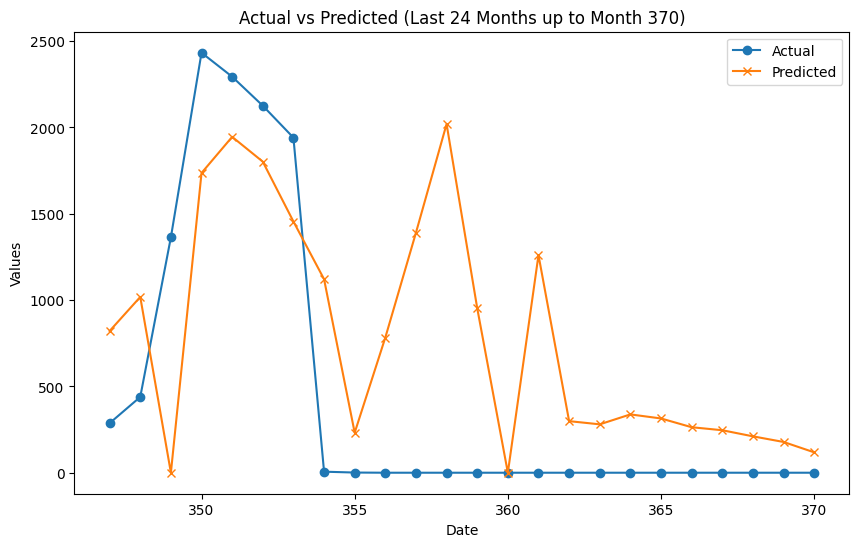

In [66]:
# Define the window size
window_size = 24

# function to plot the last 'window_size' data points from a given month
def plot_last_window_from_month(month, window_size):
    if month in dates_to_predict:
        month_index = list(dates_to_predict).index(month)
        
        # Ensure there are enough data points
        if month_index + 1 >= window_size:
            # Select the last 'window_size' data points up to the given month
            window_dates = dates_to_predict[month_index + 1 - window_size:month_index + 1]
            window_ground_truth = ground_truth[month_index + 1 - window_size:month_index + 1]
            window_predictions = predictions[month_index + 1 - window_size:month_index + 1]

            # Plot the smaller subset
            plt.figure(figsize=(10, 6))
            plt.plot(window_dates, window_ground_truth, label='Actual', marker='o')
            plt.plot(window_dates, window_predictions, label='Predicted', marker='x')
            plt.xlabel('Date')
            plt.ylabel('Values')
            plt.title(f'Actual vs Predicted (Last {window_size} Months up to Month {month})')
            plt.legend()
            plt.show()
        else:
            print(f"Not enough data points to create a window of {window_size} months up to month {month}.")
    else:
        print(f"Month {month} is not in the dates to predict.")

# Example usage
plot_last_window_from_month(370, window_size)
